In [416]:
using LinearAlgebra
using ForwardDiff
using Plots
using OrdinaryDiffEq
using Ipopt
using MathOptInterface
const MOI = MathOptInterface
using Test
const FD = ForwardDiff
using JLD2, FileIO
using StaticArrays

include("3bp_dynamics.jl")

get_reference_traj (generic function with 1 method)

In [417]:
Nx = 6     # number of state variables
Nu = 1     # number of controls (setup as free/minimum time problem)
#h is the control for this problem 

#user selected final time. 
#will select
#Tfinal = 3.01

#Nt = Int(Tfinal/h)+1   # number of time steps

#Nt = 50 #set the number of knot points

#h = Tfinal/(Nt-1)


#Determine amount of knot points
#one_min = 60/h_s #number of timesteps for 1 minute
#min_day = 1440 #number of minutes this is a day
#num_days = 5 #120 # 3 days original
#t_f=num_days*min_day 
#Nt = Int(one_min*t_f) #time steps for duration



#thist = Array(range(0, t_f, step=h_rk4));

#n_nlp = (Nx+Nu)*Nt # number of decision variables
#m_nlp = Nx*(Nt+1)

In [418]:
Tfinal = 3.057
Nt = 50              # Number of knot points --> generates number of time steps-52
#initially 50
h = Tfinal/(Nt - 1)  # Timestep

thist = Array(range(0, Tfinal, step = h)); 
n_nlp = (Nx + Nu)*Nt # Number of decision variables-350
m_nlp = Nx*(Nt)  # 306
#u_idx = [(Nx + Nu)*(i - 1) .+ (Nx + 1:Nx + Nu) for i = 1:Nt];
#x_idx = [(Nx + Nu)*(i - 1) .+ (1:Nx) for i = 1:Nt];

In [419]:
n_nlp

350

In [420]:
function unpackZ(Z)
    X = [Z[xi] for xi in xinds]
    U = [Z[ui] for ui in uinds]
    return X, U
end

unpackZ (generic function with 1 method)

In [421]:
Nt

50

In [422]:
#this is the start position, corresponding to stable direction
#x0 = [-0.21151685614932747, 8.69459011769262e-17, 0.0,-2.27583928070302e-16, 1.770870182281887, 1.795253414404434]

x0 = [0.8222791805122408,0.0,0.0,0.0,0.13799313179964737,0.0]

6-element Vector{Float64}:
 0.8222791805122408
 0.0
 0.0
 0.0
 0.13799313179964737
 0.0

In [423]:
#setup something to pick out x indices
#setup something to pick out u indices
xinds = [((k-1)*(Nx+Nu) .+ (1:Nx)) for k = 1:Nt]
uinds = [((k-1)*(Nx+Nu) .+ (Nx+1:Nx+Nu)) for k = 1:Nt]

50-element Vector{UnitRange{Int64}}:
 7:7
 14:14
 21:21
 28:28
 35:35
 42:42
 49:49
 56:56
 63:63
 70:70
 77:77
 84:84
 91:91
 ⋮
 273:273
 280:280
 287:287
 294:294
 301:301
 308:308
 315:315
 322:322
 329:329
 336:336
 343:343
 350:350

In [424]:
#Obtain the Reference Trajectory from the linearized dynamics perturbation

uref = h*ones(Nt)
#xref = get_reference_traj(x0, h_rk4) 

50-element Vector{Float64}:
 0.062387755102040816
 0.062387755102040816
 0.062387755102040816
 0.062387755102040816
 0.062387755102040816
 0.062387755102040816
 0.062387755102040816
 0.062387755102040816
 0.062387755102040816
 0.062387755102040816
 0.062387755102040816
 0.062387755102040816
 0.062387755102040816
 ⋮
 0.062387755102040816
 0.062387755102040816
 0.062387755102040816
 0.062387755102040816
 0.062387755102040816
 0.062387755102040816
 0.062387755102040816
 0.062387755102040816
 0.062387755102040816
 0.062387755102040816
 0.062387755102040816
 0.062387755102040816

In [425]:
using DelimitedFiles
xref = (readdlm("richardson.txt", '\t', Float64, '\n'))'
#Xref = [x_ref_rich[:,i] for i = 1:Nt]

6×100 adjoint(::Matrix{Float64}) with eltype Float64:
 0.988914     0.988917      0.988929     …   0.988917      0.988914
 0.0         -0.000264585  -0.000528109      0.000264585   8.47102e-18
 1.09789e-5   1.09613e-5    1.09085e-5       1.09613e-5    1.09789e-5
 0.0         -0.000238968  -0.00047667       0.000238968   7.40272e-18
 0.00857241   0.00855521    0.00850374       0.00855521    0.00857241
 0.0          1.14076e-6    2.27714e-6   …  -1.14076e-6   -3.715e-20

In [426]:
size(x_ref_rich)

LoadError: UndefVarError: x_ref_rich not defined

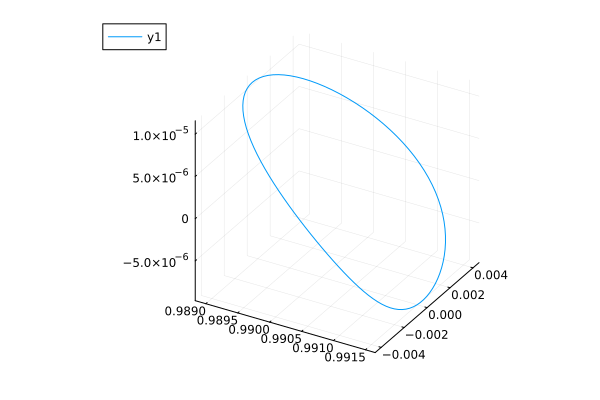

In [427]:
plot(xref[1,:], xref[2,:], xref[3,:])

#plot(x_ref_rich[1,:], x_ref_rich[2,:], x_ref_rich[3,:])

In [428]:
h_rk4

0.00026612390119354454

In [429]:
print(m_nlp)
print(n_nlp)

300350

In [430]:
function jac_c!(prob::MOI.AbstractNLPEvaluator, jac, Z)


    jac.=0
    
    #Need to reshape to a matrix
    jac = reshape(jac,prob.m_nlp,prob.n_nlp)
    
    #print("size of jacobian")
    #display(size(jac))

    #Evaluate dynamics and update the nlp struct

    #evaluate_dynamics_jacobians!(nlp, Z)
    #evaluate_midpoint_jacobians!(nlp, Z)
    
    x_, h_ = unpackZ(Z) 
    
    n_= 0
    
    idx = xinds[1]
    
    for k = 1:Nt-1
        idx = idx .+ n_
        
        x1,x2 = Z[xinds[k]], Z[xinds[k+1]]
        u1,u2 = Z[uinds[k]], Z[uinds[k+1]]
        #t = nlp.times[k]
        #h = nlp.times[k+1] - nlp.times[k]

        jac_x1 = view(jac, idx, xinds[k])
        jac_u1 = view(jac, idx, uinds[k])
        jac_x2 = view(jac, idx, xinds[k+1])
        
        #dynamics call at x1 and x2
        f1 = threebp_dynamics(x1)
        f2 = threebp_dynamics(x2)
        
        #f1 = CR3BPdynamics(x1)
        #f2 = CR3BPdynamics(x2)
        
        
        
        #obtain Jacobian wrt x1 and x2
        A1 = FD.jacobian(threebp_dynamics, x1)
        A2 = FD.jacobian(threebp_dynamics, x2)
        
        #midpoint approx
        xm = 0.5.*(x1 + x2) .+ (h/8.0).*(f1 - f2) 
        
        #jacobian at the midpoint
        Am = ForwardDiff.jacobian(threebp_dynamics,xm)
        
        #constraint jacobians (dc/dx_)
        dx1 = Am*(0.5*I + (h_[k][1]/8)*A1) +(3/(2*h_[k][1]))*I + 0.25*A1 
        du1 = Am*((1/8)*(f1-f2)) - (3/(2*h_[k][1]^2))*(x1-x2)
        dx2 =Am*(0.5*I + (h_[k][1]/8)*(-A2)) - (3/(2*h_[k][1]))*I + 0.25*A2

        jac_x1 .= dx1
        jac_u1 .= du1
        jac_x2 .= dx2
        n_ = Nx
    end
    idx = idx .+ n_
    
    #periodicity constraint jacobian!
    for i = 1:Nx
        jac[idx[i], xinds[1][i]] = -1
        jac[idx[i], xinds[end][i]] = 1
    end



end

jac_c! (generic function with 1 method)

In [431]:
function dircol_dynamics(x1,x2,h_)
    #Hermite-Simpson integration with first-order hold on u
    f1 = threebp_dynamics(x1) #dynamics eval at x1
    f2 = threebp_dynamics(x2) #dynamics eval tat x2
    
    #f1 = CR3BPdynamics(x1) #dynamics eval at x1
    #f2 = CR3BPdynamics(x2) #dynamics eval tat x2

    xm = 0.5.*(x1 + x2) .+ (h_/8.0).*(f1 - f2) 
    #um = 0.5*(u1 + u2) #first order hold on controls
    ẋm = (-3/(2.0*h_)).*(x1 - x2) .- 0.25.*(f1 + f2) #approximate dynamics at the midpoint from spline approx
    fm = threebp_dynamics(xm) #actual dynamics at the midpoint
    
    #fm = CR3BPdynamics(xm)
    return fm - ẋm #this is the dynamics constraint!!
end

dircol_dynamics (generic function with 1 method)

In [432]:
# Cost weights
Q = Diagonal([0.95*ones(3); 0.95*ones(3)]); #scales the difference in x and xref
R = 0.001; #scales the difference between u and uref
#0.001

In [433]:
function stage_cost(x,u, xref, uref)
    return 0.5*((x-xref)'*Q*(x-xref)) + 0.5*(u-uref)'*R*(u-uref) #cost at one step
end

stage_cost (generic function with 1 method)

In [434]:
#objective funciton for IpOpt
function objective(ztraj)
    z = reshape(ztraj,Nx+Nu,Nt)
    J = 0.0 #initial cost
    
    #this gets the total cost
    for k = 1:Nt
        #pass in the corresponding state and control to stage cost
        J += stage_cost(z[1:Nx,k],z[(Nx+Nu),k], xref[:,k], uref[k])
    end
    return J
end

objective (generic function with 1 method)

In [435]:
#Boilerplate setup code to interface with IPOPT. 

struct ProblemMOI <: MOI.AbstractNLPEvaluator
    n_nlp::Int
    m_nlp::Int
    idx_ineq
    obj_grad::Bool
    con_jac::Bool
    sparsity_jac
    sparsity_hess
    primal_bounds
    constraint_bounds
    hessian_lagrangian::Bool
end

function ProblemMOI(n_nlp,m_nlp;
        idx_ineq=(1:0),
        obj_grad=true,
        con_jac=true,
        sparsity_jac=sparsity_jacobian(n_nlp,m_nlp),
        sparsity_hess=sparsity_hessian(n_nlp,m_nlp),
        primal_bounds=primal_bounds(n_nlp),
        constraint_bounds=constraint_bounds(m_nlp,idx_ineq=idx_ineq),
        hessian_lagrangian=false)

    ProblemMOI(n_nlp,m_nlp,
        idx_ineq,
        obj_grad,
        con_jac,
        sparsity_jac,
        sparsity_hess,
        primal_bounds,
        constraint_bounds,
        hessian_lagrangian)
end


#all these defined in nlp.jl
function constraint_bounds(m; idx_ineq=(1:0))
    c_l = zeros(m)

    c_u = zeros(m)
    #c_u[idx_ineq] .= Inf
    
    return c_l, c_u
end

function row_col!(row,col,r,c)
    for cc in c
        for rr in r
            push!(row,convert(Int,rr))
            push!(col,convert(Int,cc))
        end
    end
    return row, col
end

function sparsity_jacobian(n,m)

    row = []
    col = []

    r = 1:m
    c = 1:n

    row_col!(row,col,r,c)

    return collect(zip(row,col))
end

function sparsity_hessian(n,m)

    row = []
    col = []

    r = 1:m
    c = 1:n

    row_col!(row,col,r,c)

    return collect(zip(row,col))
end

function MOI.eval_objective(prob::MOI.AbstractNLPEvaluator, x)
    objective(x)
end

function MOI.eval_objective_gradient(prob::MOI.AbstractNLPEvaluator, grad_f, x)
    ForwardDiff.gradient!(grad_f,objective,x)
    return nothing
end

function MOI.eval_constraint(prob::MOI.AbstractNLPEvaluator,g,x)
    constraint!(g,x)
    return nothing
end


#INPUT THE CONSTRAINT JACOBIAN HERE
function MOI.eval_constraint_jacobian(prob::MOI.AbstractNLPEvaluator, jac, x)
    jac_c!(prob,jac, x)
    return nothing
end

function MOI.features_available(prob::MOI.AbstractNLPEvaluator)
    return [:Grad, :Jac]
end

MOI.initialize(prob::MOI.AbstractNLPEvaluator, features) = nothing
MOI.jacobian_structure(prob::MOI.AbstractNLPEvaluator) = prob.sparsity_jac

function solve(x0,prob::MOI.AbstractNLPEvaluator;
        tol=1.0e-9,c_tol=1.0e-9,max_iter=500)
    x_l, x_u = prob.primal_bounds
    c_l, c_u = prob.constraint_bounds

    print("")
    nlp_bounds = MOI.NLPBoundsPair.(c_l,c_u)
    block_data = MOI.NLPBlockData(nlp_bounds,prob,true)

    solver = Ipopt.Optimizer()
    solver.options["max_iter"] = max_iter
    solver.options["tol"] = tol
    solver.options["constr_viol_tol"] = c_tol
    
    #Uncomment the following line to turn off verbose IPOPT output
    #solver.options["print_level"] = 0

    x = MOI.add_variables(solver,prob.n_nlp)

    for i = 1:prob.n_nlp
        xi = MOI.SingleVariable(x[i])
        
        #MOI.add_constraint(solver, x[i], MOI.LessThan(x_u[i]))
        #MOI.add_constraint(solver, x[i], MOI.GreaterThan(x_l[i]))
        #MOI.set(solver, MOI.VariablePrimalStart(), x[i], x0[i])
        
        MOI.add_constraint(solver, xi, MOI.LessThan(x_u[i]))
        MOI.add_constraint(solver, xi, MOI.GreaterThan(x_l[i]))
        MOI.set(solver, MOI.VariablePrimalStart(), x[i], x0[i])
        
    end

    # Solve the problem
    MOI.set(solver, MOI.NLPBlock(), block_data)
    MOI.set(solver, MOI.ObjectiveSense(), MOI.MIN_SENSE)
    MOI.optimize!(solver)

    # Get the solution
    res = MOI.get(solver, MOI.VariablePrimal(), x)

    return res
end

solve (generic function with 1 method)

In [436]:
#constraint functions for IPOPT

#OLD
# function constraint!(c,Z)
    
#     #reshape Z to a (Nx+Nu)xNt array
    
#     #c = reshape(c,Nx,Nt-1) 
    
#     c = reshape(c,Nx,Nt) 
#     z = reshape(Z, Nx+Nu, Nt)  

#     for k=1:Nt-1
#         idx = xinds[k]
#         x1 = z[1:Nx,k]
#         u1 = z[1:Nx,k]
#         x2 = z[Nx+Nu,k+1]
        
        
#         #set a dynamics constraint
#         c[:,k] .= dircol_dynamics(x1,x2,u1) 
        
#         print("gg")
#     end
    
#     #set the periodicity constraint
#     #the final state should be the initial
#     c[(end-Nx+1):end] .= z[1:Nx, end] - z[1:Nx, 1] 
    
#     return nothing
# end

#Specify the indicies of c (constraint output) that should be non-negative.
#The rest will be treated as equality constraints.
#This can vary depending on how you stacked up c above.

#nonnegative_constraint_indices = (8:23) # update this

function primal_bounds(n)
    #Enforce simple bound constraints on the decision variables (e.g. positivity) here
    
    x_l = -Inf*ones(n)
    x_u = Inf*ones(n)
    
    #set an upper and lower bound for every timestep (bound time)
    for k = 1:Nt
        
        x_l[uinds[k]] .= h*0.01 
        #x_u[uinds[k]] .= h*1.5 
        #kinda works (best one)
        x_u[uinds[k]] .= h*2.3 
        #x_u[uinds[k]] .= h*2.25
        #2.28 works good too
    end
    
    
    return x_l, x_u
end

primal_bounds (generic function with 1 method)

In [437]:
#WORKS
function dynamics_constraint!(c,ztraj) where {n,m}
    d = reshape(c,Nx,Nt-1) 
    z = reshape(ztraj,Nx+Nu,Nt) #ztraj[7,50]
    for k = 1:(Nt-1)
        x1 = z[1:Nx,k]
        u1 = z[(Nx+1):(Nx+Nu),k]
        x2 = z[1:Nx,k+1]
        d[:,k] = dircol_dynamics(x1,x2,u1)
    end
    return nothing
end

function constraint!(c,ztraj) where {n,m}
    z = reshape(ztraj,Nx+Nu,Nt)#7 x 50
    @views dynamics_constraint!(c[1:(end-Nx)],ztraj)
    #Periodicity Constraint 
    c[(end-Nx+1):end] .= z[1:Nx,end] - z[1:Nx,1]
end

constraint! (generic function with 1 method)

In [438]:
xinds[1]

1:6

In [439]:
xref

6×100 adjoint(::Matrix{Float64}) with eltype Float64:
 0.988914     0.988917      0.988929     …   0.988917      0.988914
 0.0         -0.000264585  -0.000528109      0.000264585   8.47102e-18
 1.09789e-5   1.09613e-5    1.09085e-5       1.09613e-5    1.09789e-5
 0.0         -0.000238968  -0.00047667       0.000238968   7.40272e-18
 0.00857241   0.00855521    0.00850374       0.00855521    0.00857241
 0.0          1.14076e-6    2.27714e-6   …  -1.14076e-6   -3.715e-20

In [440]:
# #Guess
# xguess = kron(ones(Nt)', x0)
# xguess[1,:] .= xtraj[1,:] + 0.1*randn(Nt)
# uguess = zeros(Nt)'
# z0 = reshape([xguess; uguess],(Nx+Nu)*Nt,1);



#Guess
z0 = zeros((Nx+Nu)*(Nt))

z0[xinds[1]] = xref[:,1]
for k=1:Nt
    z0[xinds[k]] = xref[:,k]
    z0[uinds[k]] .= uref[k]
end
     


In [441]:
size(z0)

(350,)

In [442]:
prob = ProblemMOI(n_nlp,m_nlp)
z_sol = solve(z0,prob) # solve
ztraj = reshape(z_sol,Nx+Nu,Nt)
xtraj = ztraj[1:Nx,:]
utraj = ztraj[(Nx+1):(Nx+Nu),:];

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:   105000
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      350
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       50
                     variables with only upper bounds:        0
Total number of equality constraints.................:      300
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [443]:
ztraj = reshape(z_sol,Nx+Nu,Nt);
xtraj = ztraj[1:Nx,:];#6 x 50
utraj = ztraj[(Nx+1):(Nx+Nu),:]; # 1 x 91
xonly = xtraj[1,:];
yonly = xtraj[2,:];
zonly = xtraj[3,:];


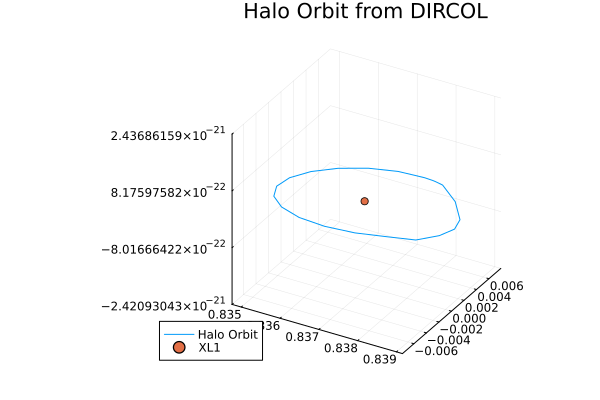

In [444]:
plot(xonly, yonly, zonly, title = "Halo Orbit from DIRCOL", label = "Halo Orbit")
XL1 = [0.8369180073169304, 0, 0, 0, 0, 0]
scatter!([XL1[1]], [XL1[2]], [XL1[3]], label = "XL1")

In [447]:
#Compute stable and unstable manifolds
using DelimitedFiles

writedlm("halo.txt", ztraj)


In [328]:
ztraj

7×50 Matrix{Float64}:
  0.838565      0.838052      0.837416     …   0.838903      0.838565
 -0.00484572   -0.00644152   -0.00731793      -0.00270695   -0.00484572
  2.12471e-21   2.29938e-21   2.22954e-21      1.72263e-21   2.12471e-21
 -0.00301604   -0.00407265   -0.00471268      -0.00166674   -0.00301604
 -0.0132601    -0.00877548   -0.0033289       -0.0162701    -0.0132601
  2.04515e-21   3.69612e-22  -1.33184e-21  …   3.51155e-21   2.04515e-21
  0.143492      0.143492      0.143492         0.143492      0.0625027

In [182]:
XL1

LoadError: UndefVarError: XL1 not defined

In [59]:
yonly

50-element Vector{Float64}:
  0.13128348240567334
  0.1312518871238517
  0.13121442536594166
  0.13116804774442842
  0.13110648064668873
  0.1297245731939666
  0.12095078440796106
  0.103894080443753
  0.07694464641807834
  0.03830254664599315
 -0.009375389019139825
 -0.05452469573230472
 -0.08851465853781888
  ⋮
  0.1314525085748456
  0.13144851220545095
  0.1314406066813057
  0.13143032605760188
  0.13141822488378024
  0.13140450298199105
  0.13138919668533
  0.13137224272435563
  0.13135349525528495
  0.13133271850272685
  0.13130955809120917
  0.13128348240567334

In [60]:
xonly

50-element Vector{Float64}:
 0.9765888862158485
 0.9763490301446384
 0.9760881610141997
 0.9757924411029073
 0.975435265387422
 0.9707275230437781
 0.9580745690257603
 0.944067561906467
 0.9287064707060246
 0.9150262162706695
 0.9107867515478167
 0.9196595444089247
 0.9346336819374206
 ⋮
 0.9792356488183512
 0.9788653439688286
 0.9785648981351807
 0.9783036916409573
 0.9780662978428096
 0.9778439546249201
 0.9776310887490947
 0.9774237431744877
 0.9772187670458681
 0.9770133214442815
 0.9768044937918734
 0.9765888862158485